In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Multiply, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.metrics import MeanSquaredError

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
df_ratings = pd.read_pickle('/content/drive/My Drive/df_ratings_100k.pkl')
df_movies = pd.read_pickle('/content/drive/My Drive/df_movies_cleaned.pkl')

# 1. Preprocessing

## 1.1 Convert UserId & MovieId

In a collaborative filtering model, user IDs and movie IDs need to be converted to a continuous range of integers, which will serve as array indices in the embedding layers. Neural network models, particularly those using embeddings, benefit from having user and movie indices start from zero and continue without gaps. This is because each index directly accesses a position in the embedding matrix. This step ensures that each user and movie can be uniquely identified with a dense vector in the latent space.

In [50]:
# Combine all movie IDs and user IDs from both dataframes to ensure comprehensive encoding
all_movie_ids = pd.concat([df_ratings['movieId'], df_movies['movieId']]).unique()
all_user_ids = df_ratings['userId'].unique()

# Create and fit the encoders
movie_encoder = LabelEncoder()
user_encoder = LabelEncoder()

movie_encoder.fit(all_movie_ids)
user_encoder.fit(all_user_ids)

# Transform movie and user IDs in the both dataframes
df_ratings['user'] = user_encoder.transform(df_ratings['userId'])
df_ratings['movie'] = movie_encoder.transform(df_ratings['movieId'])
df_movies['movie'] = movie_encoder.transform(df_movies['movieId'])

In [51]:
# Check Encoding:

num_users = df_ratings['user'].nunique()
num_movies = df_ratings['movie'].nunique()

print("Unique users in ratings:", num_users)
print("Unique movies in ratings:", num_movies)
print("Min/Max user IDs:", df_ratings['user'].min(), '/', df_ratings['user'].max())
print("Min/Max movie IDs:", df_ratings['movie'].min(), '/', df_ratings['movie'].max())

Unique users in ratings: 55588
Unique movies in ratings: 9494
Min/Max user IDs: 0 / 55587
Min/Max movie IDs: 0 / 39082


User IDs appear to be correctly encoded. We have 55,588 unique users, and the user IDs range from 0 to 55,587, which suggests that every unique user ID has been mapped to a unique integer in a contiguous zero-based range.

Movie IDs, however, show a discrepancy. While there are 9,494 unique movies, the movie IDs range from 0 to 39,082. This gap indicates that not all possible integer values between 0 and 39,082 are used, suggesting that there are missing IDs within this range. Therefore, we will remap the movie IDs to a new contiguous range.

In [52]:
# Recreate the mapping from the sorted unique IDs
movie_id_map = {id: i for i, id in enumerate(sorted(df_ratings['movieId'].unique()))}

# Apply the new mapping to the DataFrames
df_ratings['movie'] = df_ratings['movieId'].apply(lambda x: movie_id_map.get(x, -1))  # Use get to avoid errors
df_movies['movie'] = df_movies['movieId'].apply(lambda x: movie_id_map.get(x, -1))

# Check again
print("New max movie ID in ratings:", df_ratings['movie'].max())
print("New unique movie IDs in ratings:", df_ratings['movie'].nunique())

New max movie ID in ratings: 9493
New unique movie IDs in ratings: 9494


In [53]:
print(df_ratings[['movieId', 'movie']].head())
print(df_movies[['movieId', 'movie']].head())

          movieId  movie
11800835     1037    829
3192182     27316   5716
10041143      307    269
14911364    73929   7389
13024846     4308   3281
   movieId  movie
0        1      0
1        2      1
2        3      2
3        4      3
4        5      4


The mapping has now been applied correctly. The movie IDs now range from 0 to 9493, which matches exactly with the count of unique movie IDs (9494), implying that the IDs are perfectly contiguous and zero-indexed. Let's do a final validation check to confirm that no movieId is left unmapped and no erroneous transformations have occurred:

In [55]:
# Ensure that all movies referenced in ratings are available in the movies DataFrame
missing_movies = df_ratings[~df_ratings['movie'].isin(df_movies['movie'])]
if missing_movies.empty:
    print("All movies in ratings are accounted for in the movies dataframe.")
else:
    print(f"There are {missing_movies.shape[0]} missing movies in the movies dataframe.")

There are 781 missing movies in the movies dataframe.


The presence of 781 missing movies in the df_movies DataFrame compared to df_ratings indicates that there are movies which have been rated but for which there is no additional metadata available in the df_movies dataset. Those rows will be dropped as they are not significant for the model.

In [56]:
# Removing ratings with missing movie metadata
df_ratings = df_ratings[df_ratings['movie'].isin(df_movies['movie'])]

# Check again
missing_movies_after = df_ratings[~df_ratings['movie'].isin(df_movies['movie'])]
if missing_movies_after.empty:
    print("All movies in ratings are now accounted for in the movies dataframe.")
else:
    print(f"There are still {missing_movies_after.shape[0]} missing movies in the movies dataframe.")

All movies in ratings are now accounted for in the movies dataframe.


The data is now correctly encoded and we can move on to the next preprocessing step.

## 1.2 Normalize Ratings

Next, we normalize the ratings as this helps the model train faster and converge more easily.

In [58]:
# Normalize the ratings to a scale of 0 to 1
df_ratings['rating_norm'] = (df_ratings['rating'] - 0.5) / 4.5

In [59]:
# Check Normalization:

print("Min/Max normalized ratings:", df_ratings['rating_norm'].min(), "/", df_ratings['rating_norm'].max())
print(df_ratings[['rating', 'rating_norm']].head())

Min/Max normalized ratings: 0.0 / 1.0
          rating  rating_norm
11800835     0.5          0.0
3192182      0.5          0.0
10041143     0.5          0.0
14911364     0.5          0.0
13024846     0.5          0.0


## 1.3 Prepare Data for Modelling

Now, we split the data into training and test data. For recommendation tasks, a chronological split makes more sense than a random split because user preferences and item popularity can change over time. Using a chronological split can simulate a real-world scenario where a model trained on past data is used to predict future preferences. This approach helps in evaluating how well the model might perform when deployed in production, as it mimics the model's need to work with new, unseen data arriving over time.

In [61]:
# Sort data chronologically
df_ratings = df_ratings.sort_values(by='timestamp')

# Define a cutoff for splitting the data (80% train, 20% test)
cutoff = int(len(df_ratings) * 0.8)
train_df = df_ratings.iloc[:cutoff]
test_df = df_ratings.iloc[cutoff:]

In [62]:
# Separate user and item IDs for training and testing
X_train_user = train_df['user'].values
X_train_item = train_df['movie'].values
y_train = train_df['rating_norm'].values

X_test_user = test_df['user'].values
X_test_item = test_df['movie'].values
y_test = test_df['rating_norm'].values

# Convert to TensorFlow tensors
X_train_user = tf.convert_to_tensor(X_train_user, dtype=tf.int32)
X_train_item = tf.convert_to_tensor(X_train_item, dtype=tf.int32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

X_test_user = tf.convert_to_tensor(X_test_user, dtype=tf.int32)
X_test_item = tf.convert_to_tensor(X_test_item, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [64]:
# Verify the shapes of the tensors
print(f"X_train_user shape: {X_train_user.shape}")
print(f"X_train_item shape: {X_train_item.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_test_user shape: {X_test_user.shape}")
print(f"X_test_item shape: {X_test_item.shape}")
print(f"y_test shape: {y_test.shape}")

X_train_user shape: (79375,)
X_train_item shape: (79375,)
y_train shape: (79375,)
X_test_user shape: (19844,)
X_test_item shape: (19844,)
y_test shape: (19844,)


In [65]:
# Check Train-Test-Split:
print("Train data range from {} to {}".format(train_df['timestamp'].min(), train_df['timestamp'].max()))
print("Test data range from {} to {}".format(test_df['timestamp'].min(), test_df['timestamp'].max()))

Train data range from 1996-02-15 12:59:58 to 2015-03-06 06:45:43
Test data range from 2015-03-06 08:41:40 to 2017-08-04 03:38:23


# 2. Model Building

## 2.1 Define the NCF Model Architecture

In [79]:
# Define model parameters
embedding_size = 10

# GMF part
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

user_embedding_gmf = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding_gmf')(user_input)
item_embedding_gmf = Embedding(input_dim=num_movies, output_dim=embedding_size, name='item_embedding_gmf')(item_input)
gmf_vector = Multiply()([Flatten()(user_embedding_gmf), Flatten()(item_embedding_gmf)])

# MLP part
user_embedding_mlp = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding_mlp')(user_input)
item_embedding_mlp = Embedding(input_dim=num_movies, output_dim=embedding_size, name='item_embedding_mlp')(item_input)
mlp_vector = Concatenate()([Flatten()(user_embedding_mlp), Flatten()(item_embedding_mlp)])

mlp_vector = Dense(64, activation='relu')(mlp_vector)
mlp_vector = Dense(32, activation='relu')(mlp_vector)
mlp_vector = Dense(16, activation='relu')(mlp_vector)

# Combine GMF and MLP parts
concatenated = Concatenate()([gmf_vector, mlp_vector])
result = Dense(10, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(result)

model = Model(inputs=[user_input, item_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae', MeanSquaredError(name='mse')])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 item_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding_mlp (Embedd  (None, 1, 10)                555880    ['user_input[0][0]']          
 ing)                                                                                             
                                                                                                  
 item_embedding_mlp (Embedd  (None, 1, 10)                94940     ['item_input[0][0]']    

## 2.2 Train the model

In [80]:
# Train the model
history = model.fit(
    [X_train_user, X_train_item],
    y_train,
    epochs=20,
    batch_size=256,
    validation_data=([X_test_user, X_test_item], y_test)
)

Epoch 1/20
311/311 [==============================] - 7s 19ms/step - loss: 0.0520 - mae: 0.1802 - mse: 0.0520 - val_loss: 0.0536 - val_mae: 0.1786 - val_mse: 0.0536
Epoch 2/20
311/311 [==============================] - 5s 17ms/step - loss: 0.0367 - mae: 0.1454 - mse: 0.0367 - val_loss: 0.0558 - val_mae: 0.1810 - val_mse: 0.0558
Epoch 3/20
311/311 [==============================] - 6s 19ms/step - loss: 0.0251 - mae: 0.1184 - mse: 0.0251 - val_loss: 0.0573 - val_mae: 0.1860 - val_mse: 0.0573
Epoch 4/20
311/311 [==============================] - 7s 21ms/step - loss: 0.0161 - mae: 0.0940 - mse: 0.0161 - val_loss: 0.0581 - val_mae: 0.1875 - val_mse: 0.0581
Epoch 5/20
311/311 [==============================] - 6s 19ms/step - loss: 0.0075 - mae: 0.0654 - mse: 0.0075 - val_loss: 0.0580 - val_mae: 0.1860 - val_mse: 0.0580
Epoch 6/20
311/311 [==============================] - 4s 14ms/step - loss: 0.0040 - mae: 0.0483 - mse: 0.0040 - val_loss: 0.0585 - val_mae: 0.1879 - val_mse: 0.0585
Epoch 7/20

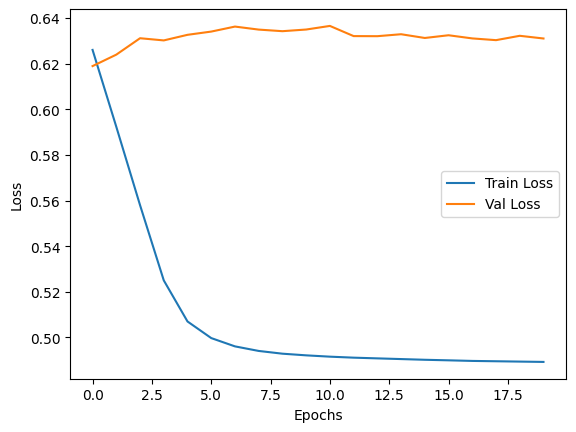

In [75]:
# Plot the training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 2.3 Evaluate the model